In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict

dict_losses = defaultdict(list)
with open("log/per_token_loss_3.txt", "r") as f:
    for line in f:
        if 'val' in line:
            continue
        losses = line.split('train')[-1].strip().split('|')
        for loss in losses:
            i, val = loss.strip().split(":")
            i = int(i)
            val = abs(float(val))
            dict_losses[i].append(val)

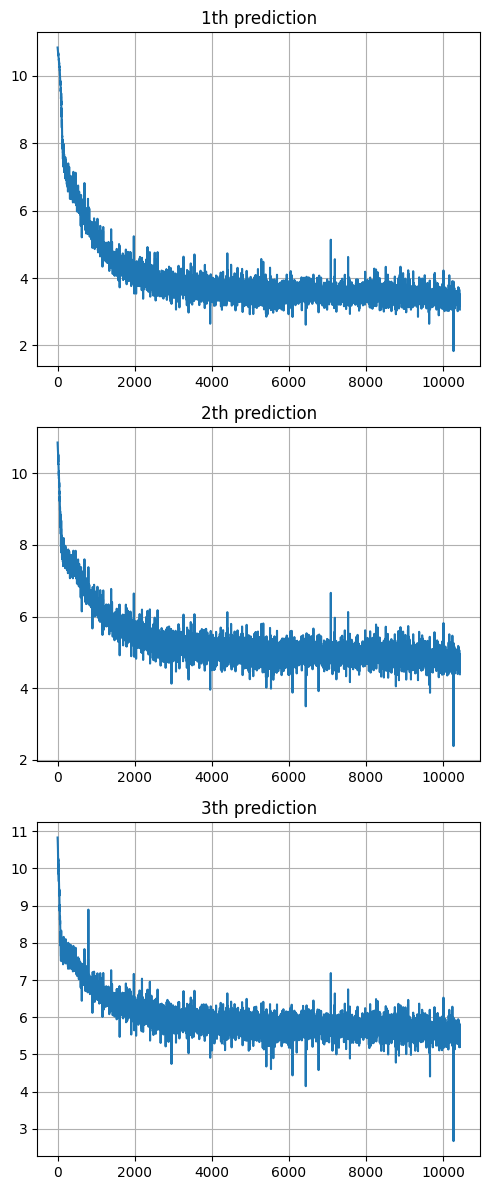

In [8]:
fig, axes = plt.subplots(nrows=len(dict_losses), ncols=1, figsize=(5, 4*len(dict_losses)))
gamma = 1.0
# Extract loss values from dictionary
for i in range(1, len(dict_losses)+1):
    dict_losses[i] = [val/(gamma**(i-1)) for val in dict_losses[i]]
    axes[i-1].plot(range(len(dict_losses[i])), dict_losses[i])
    axes[i-1].grid(True)
    axes[i-1].set_title(f'{i}th prediction')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [1]:
import torch
import tiktoken
from model import GPTk

tokenizer = tiktoken.get_encoding("gpt2")
cpt = torch.load('log/cpt.pt', map_location='cpu', weights_only=False)
cpt.keys()

dict_keys(['model', 'config', 'step', 'val_loss'])

In [2]:
model = GPTk(cpt['config'])
model.load_state_dict(cpt['model'])

number of parameters: 181.84M


<All keys matched successfully>

In [5]:
from torch.nn import functional as F

def generate_and_print_next_k_tokens(
    seq: str,
    model: GPTk,
    k: int=4,
    max_new_tokens: int = 10
) -> None:
    
    tokens = tokenizer.encode(seq)
    tokens = torch.tensor([tokens])

    for _ in range(max_new_tokens):
        logits = model(tokens)
        next_tokens, next_token_probs = [], []
        for i in range(k):
            next_tokens.append(torch.argmax(logits[i][:, -1, :], dim=-1).squeeze().item())
            max_val, _ = torch.max(F.softmax(logits[i], dim=-1), dim=-1)
            next_token_probs.append(max_val[0][0].item())
        
        print(tokenizer.decode(tokens[0].tolist()), end='')
        for tok, prob in zip(next_tokens, next_token_probs):
            tok_s = tokenizer.decode([tok])
            print(f" | {tok_s}({prob:.4f})", end='')
        print()

        tokens = torch.cat(
            [tokens, torch.tensor([[next_tokens[0]]])], 
            dim=-1
        )
        # print(f'tokens: {tokens}')

In [9]:
generate_and_print_next_k_tokens(
    # seq='Hello, I am a language model,',
    seq = 'Hello,',
    model=model,
    k = len(model.lm_heads),
    max_new_tokens=10
)

Hello, |  I(0.1172) | �(0.0878) | �(0.0501)
Hello, I | �(0.1172) | �(0.0878) | m(0.0501)
Hello, I� | �(0.1172) | m(0.0878) |  going(0.0501)
Hello, I’ | m(0.1172) |  going(0.0878) |  to(0.0501)
Hello, I’m |  going(0.1172) |  to(0.0878) |  to(0.0501)
Hello, I’m going |  to(0.1172) |  be(0.0878) |  you(0.0501)
Hello, I’m going to |  write(0.1172) |  you(0.0878) |  the(0.0501)
Hello, I’m going to write |  a(0.1172) |  a(0.0878) | .(0.0501)
Hello, I’m going to write a |  new(0.1172) |  about(0.0878) |  the(0.0501)
Hello, I’m going to write a new |  article(0.1172) | .(0.0878) | 
(0.0501)
